## Bibliotecas e dados

In [62]:
#import statsmodels.api as sm
import statsmodels.tsa.api as tsa
#from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib as mpl
#import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import learning_curve

#mpl.rcParams['figure.figsize'] = [10, 5]

def show_metrics(y_test,prediction, results, name):
    print(f'{name} - model Results')
    print('r2' , r2_score(prediction, y_test))
    print('mse' ,mean_squared_error(prediction, y_test))
    print('mae', mean_absolute_error(prediction, y_test))
    print('mape', mean_absolute_percentage_error(prediction, y_test))
    results[name] = {'r2':r2_score(prediction, y_test), \
                    'mse': mean_squared_error(prediction, y_test), 
                    'mae': mean_absolute_error(prediction, y_test),
                    'mape': mean_absolute_percentage_error(prediction, y_test)}

In [6]:
#https://www.kaggle.com/datasets/mahirkukreja/delhi-weather-data
df = pd.read_csv("temp_dehli.csv")

In [7]:
df = df[["date", "meantemp"]]
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df.set_index(df['date'], inplace=True) 
df = df.drop('date', 1)


C:\Users\lucas\AppData\Local\Temp/ipykernel_16724/3726606635.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('date', 1)


In [8]:
df.head()

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


Separando dados em treino, teste e validação. Vale notar que para os modelos lineares utilizaremos apenas treino (75%) e teste (25%), enquanto que para os modelos de machine learning utilizaremos treino (50%), validação (25%) e teste (25%).

In [9]:
df_train = df.iloc[:int(len(df) * 0.75)]
df_test = df.iloc[int(len(df) * 0.75):]

#df_train2 = df.iloc[:int(len(df) * 0.5)]
#df_valid2 = df.iloc[int(len(df) * 0.5):int(len(df) * 0.75)]
#df_test2 = df.iloc[int(len(df) * 0.75):]

## Plot

<AxesSubplot:xlabel='date'>

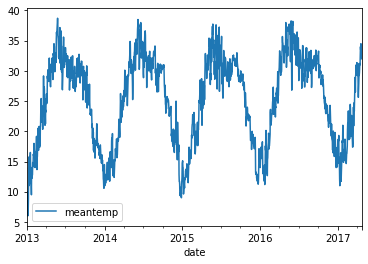

In [10]:
df.plot()

## Decomposição

Através da decomposição verificamos que há tendência... portanto a série não deve ser estacionária, vamos verificar a seguir.

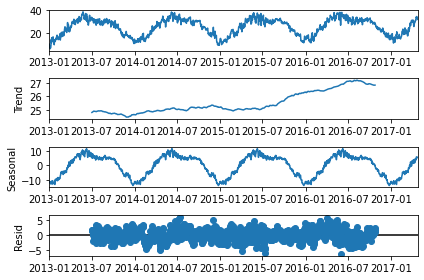

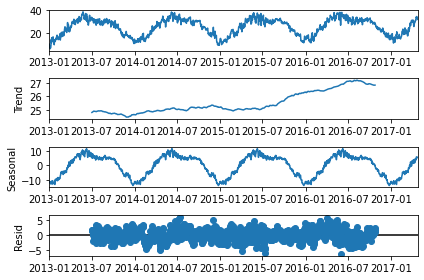

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 6, 4
df_decomp = tsa.seasonal_decompose(df, period=365)
df_decomp.plot()

## Estacionariedade

Como a função de auto correlação abaixo não decai  para zero, suspeitamos de que a série não seja estacionária. Vamos verificar a seguir por meio de um teste de hipóteses.

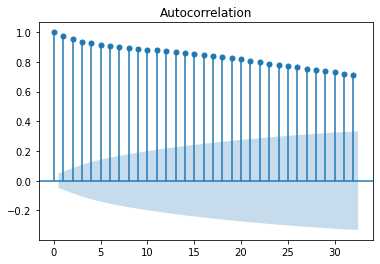

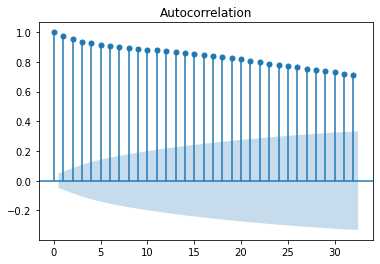

In [86]:
plot_acf(df)

Considerando um nível de confiança de 0,05 verificamos que o teste de Dickey-Fuller nos leva a não rejeitar a hipótese nula de não estacionariedade, visto que o p-valor = 0,149 (>0,05). Portanto, temos evidências para acreditar que a série não é estacionária.

In [12]:
test, pvalue, lags, obs, critic, ic = tsa.stattools.adfuller(df)
print(pvalue)
print(lags)

0.14882501558674888
10


## Diferenciação

<AxesSubplot:xlabel='date'>

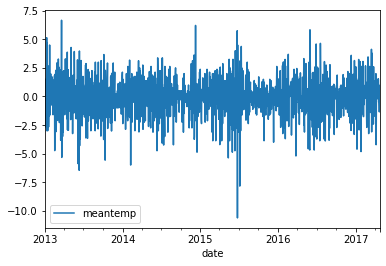

In [13]:
df.diff().plot()

Após diferenciar a série aparenta ser estacionária, vamos verificar com o teste de Dickey-Fuller.

<AxesSubplot:ylabel='Frequency'>

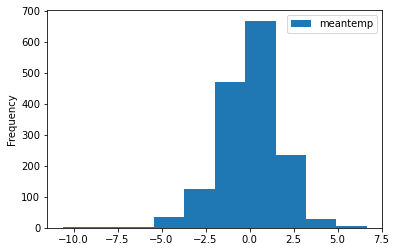

In [14]:
df.diff().plot.hist()

In [15]:
dfd1 = df.diff().dropna()

Como o p-valor<0,05 então decidimos rejeitar a hipótese nula de não estacionariedade à um nível de confiança de 0,05. Portanto, após diferenciar uma vez a série temos evidências para acreditar que a série se tornou estacionária.

In [16]:
test, pvalue, lags, obs, critic, ic = tsa.stattools.adfuller(dfd1)
print(pvalue)
print(lags)

9.593523131253509e-30
9


## Autocorrelação

### Correlação

In [17]:
df.corrwith(df.shift(1))

meantemp    0.974134
dtype: float64

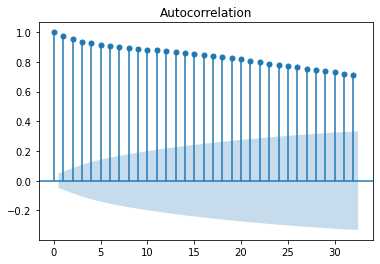

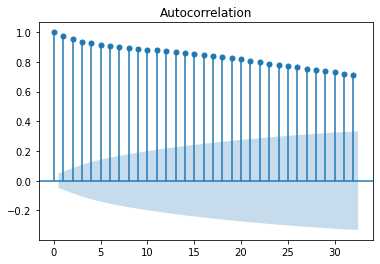

In [18]:
plot_acf(df)

Correlação com série diferenciada

In [19]:
dfd1.corrwith(dfd1.shift(1))

meantemp   -0.156369
dtype: float64

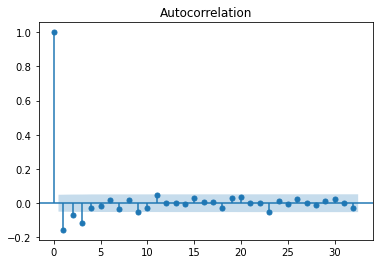

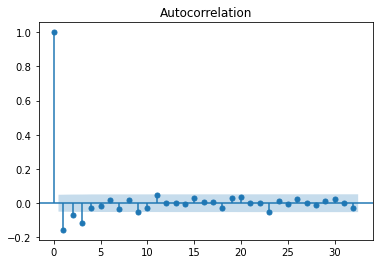

In [20]:
plot_acf(dfd1)

## Autocorrelação Parcial

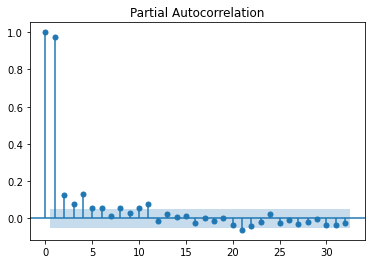

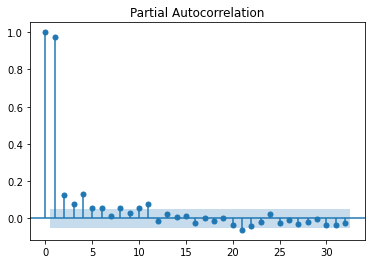

In [21]:
plot_pacf(df)

Correlação Parcial com série diferenciada

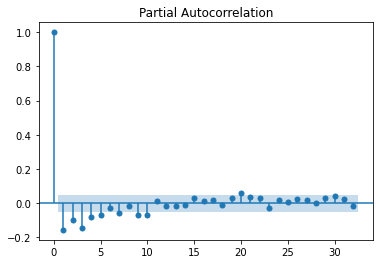

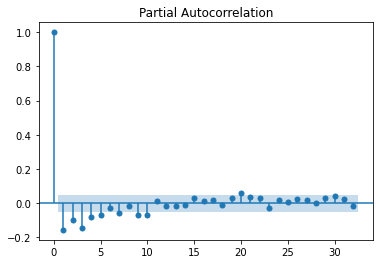

In [22]:
plot_pacf(dfd1)

### ARIMA

ARIMA (4,1,3)

In [96]:
df_train.index = pd.DatetimeIndex(df_train.index.values, freq=df_train.index.inferred_freq)
df_train.head()

,meantemp
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


In [27]:
arima_model = ARIMA(df_train, order=(4,1,3))

In [98]:
res_arima = arima_model.fit()

C:\Users\lucas\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [99]:
res_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               meantemp   No. Observations:                 1181
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -2232.546
Date:                Tue, 12 Apr 2022   AIC                           4481.092
Time:                        22:29:27   BIC                           4521.678
Sample:                    01-01-2013   HQIC                          4496.393
                         - 03-26-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1383      0.074     -1.870      0.062      -0.283       0.007
ar.L2         -0.4631      0.072     -6.461      0.000      -0.604      -0.323
ar.L3          0.5214      0.073      7.143      0.000       0.378       0.665
ar.L4          0.0246      0.035      0.712      0.477      -0.043       0.092
ma.L1         -0.0773      0.070     -1.098      0.272      -0.215       0.061
ma.L2          0.3276      0.056      5.897      0.000       0.219       0.437
ma.L3         -0.7580      0.059    -12.900      0.000      -0.873      -0.643
sigma2         2.5737      0.087     29.741      0.000       2.404       2.743
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               209.83
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.45
Prob(H) (two-sided):                  0.80   Kurtosis:                         4.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\lucas\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


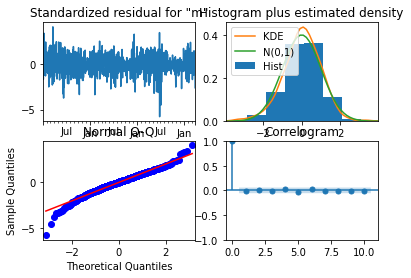

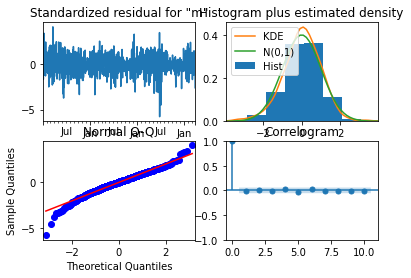

In [100]:
res_arima.plot_diagnostics()

Plotando o ajuste do modelo aos dados de treino

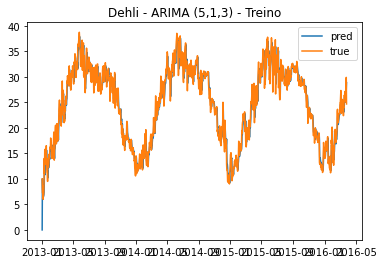

In [101]:
#Previsão do treino
fig, ax = plt.subplots()
ax.plot(res_arima.predict(), label='pred')
ax.plot(df_train, label='true')
plt.title('Dehli - ARIMA (5,1,3) - Treino')
plt.legend()

Plotando Treino, teste e a predição do modelo

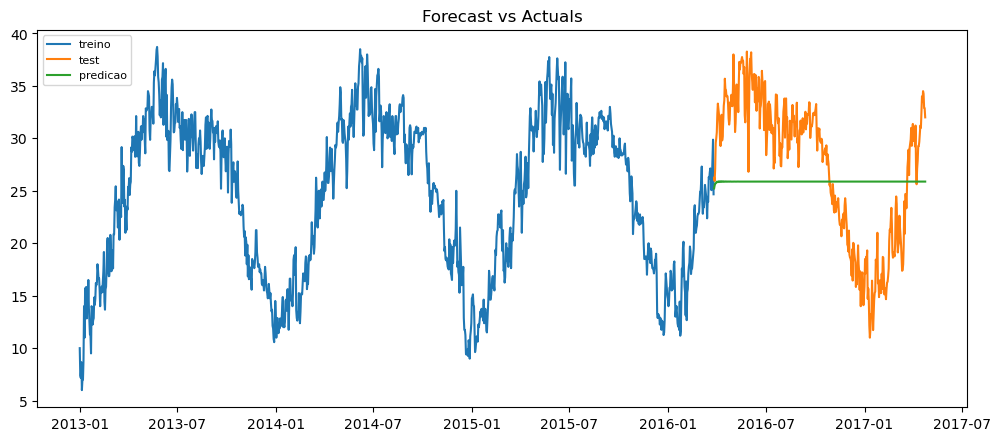

In [102]:
# Build Model 
#model = ARIMA(df_train, order=(2, 0, 1))  
fitted = res_arima  

# Forecast
fc = fitted.forecast(394, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=df_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label='treino')
plt.plot(df_test, label='test')
plt.plot(fc_series, label='predicao')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [103]:
results = {}

In [104]:
forecast = res_arima.forecast(394, alpha=0.05)
show_metrics(df_test, forecast, results, 'ARIMA(4,1,3)')

ARIMA(5,1,3) - model Results
r2 -29244.06420696393
mse 48.09442893779906
mae 6.238789808283262
mape 0.2410864250599167


#### ARIMA (0,1,3)

### Auto ARIMA

In [105]:
auto_arima = pm.auto_arima(df_train, max_ar=10, max_ma=5, max_d=2, seasonal=False, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4494.045, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11018.217, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=9511.186, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4512.618, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4492.004, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4531.154, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4493.975, Time=0.41 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.96 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4489.732, Time=0.65 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4523.647, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4531.821, Time=0.22 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4491.714, 

In [ ]:
auto_arima = pm.auto_arima(df_train, max_ar=10, max_ma=5, max_d=2, seasonal=True, trace=True, stepwise=True)

In [36]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1181
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -2239.866
Date:                Tue, 12 Apr 2022   AIC                           4489.732
Time:                        22:02:15   BIC                           4515.102
Sample:                             0   HQIC                          4499.296
                               - 1181                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0506      0.030      1.672      0.094      -0.009       0.110
ar.L1          1.5616      0.055     28.192      0.000       1.453       1.670
ar.L2         -0.5638      0.055    -10.282      0.000      -0.671      -0.456
ma.L1         -0.7881      0.045    -17.488      0.000      -0.876      -0.700
sigma2         2.5920      0.086     30.135      0.000       2.423       2.761
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               227.00
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                            -0.46
Prob(H) (two-sided):                  0.82   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\lucas\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


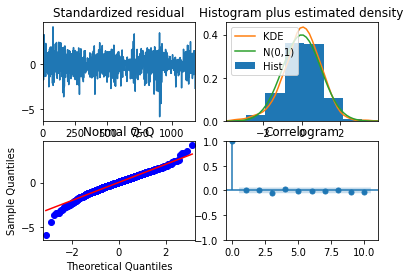

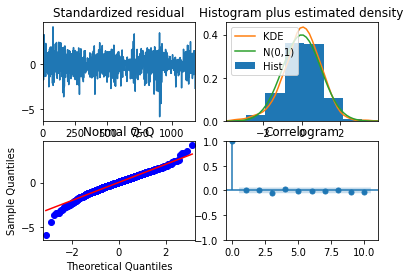

In [37]:
auto_arima.plot_diagnostics()

Plotando ajuste do modelo aos dados de treino

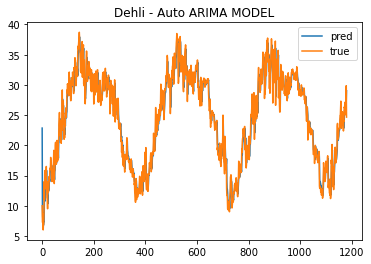

In [38]:
fig, ax = plt.subplots()
ax.plot(auto_arima.predict_in_sample(), label='pred')
ax.plot(df_train.values, label='true')
plt.title('Dehli - Auto ARIMA MODEL')
plt.legend()

Plotando Treino, teste e predição

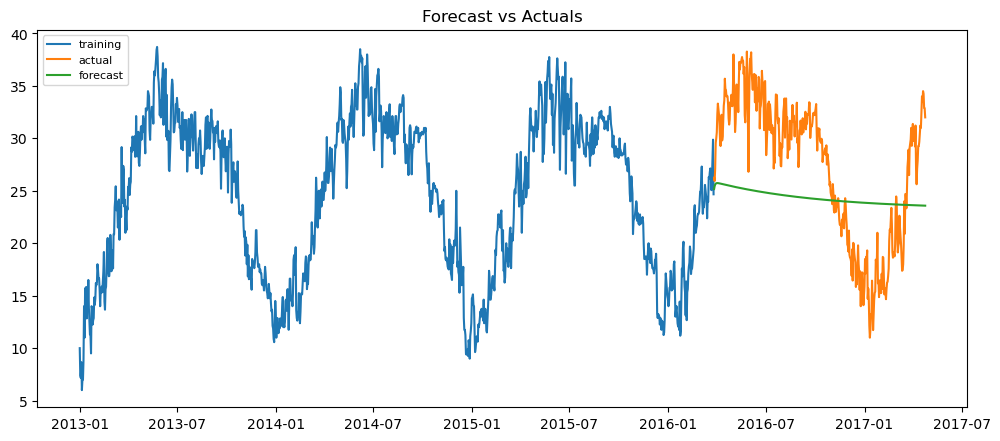

In [41]:
# Build Model 
model = ARIMA(df_train, order=(2, 0, 1))  
fitted = model.fit()  

# Forecast
fc = fitted.forecast(394, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=df_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label='training')
plt.plot(df_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [42]:
forecast = auto_arima.predict(n_periods=394)
show_metrics(df_test, forecast, results, 'ARIMA(2,0,1)')

ARIMA(2,0,1) - model Results
r2 -95.85896516856229
mse 49.68913135264666
mae 6.356182978044135
mape 0.2623335314335786


## Machine Learning

### Feature Engineering

In [44]:
#time travel
def get_lags(series, lags):
  result = []
  if lags > 0:
    for lag in range(1, lags+1):
    #  print(lag)
    #  print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'-'+str(lag)}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(-1,-lags))).dropna()
  else:
    for lag in range(-1, lags-1,-1):
      #print(lag)
      #print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'+'+str(abs(lag))}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(+1,-lags))).dropna()

In [45]:
X = get_lags(df, 3)
X.head()

,meantemp-1,meantemp-2,meantemp-3
date,,,
2013-01-04,7.166667,7.400000,10.000000
2013-01-05,8.666667,7.166667,7.400000
2013-01-06,6.000000,8.666667,7.166667
2013-01-07,7.000000,6.000000,8.666667
2013-01-08,7.000000,7.000000,6.000000


In [46]:
y = df.reindex(X.index)
y.head()

,meantemp
date,
2013-01-04,8.666667
2013-01-05,6.000000
2013-01-06,7.000000
2013-01-07,7.000000
2013-01-08,8.857143


In [47]:
#Separando os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.25)

### KNN

Utilizaremos o GridSearch para encontrar os melhores parâmetros para o NKK.

In [ ]:
#Definindo hiperpâmetros de busca do GridSearch
parameters = {'n_neighbors':range(1,20), 'weights':["uniform", "distance"]}
for p in parameters.items():
  print(p)

In [ ]:
knn = KNeighborsRegressor()
knnGS = GridSearchCV(knn, parameters, cv=TimeSeriesSplit(n_splits=10))
res = knnGS.fit(X_train, y_train)
print(res.best_score_)
print(res.best_params_)

Métricas

In [ ]:
prediction = res.predict(X_test)
show_metrics(y_test, prediction, results, 'KNN GS')

In [ ]:
fig, ax = plt.subplots()
ax.plot(prediction, label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')
plt.title('Dehli Temperature - KNN GS MODEL')
plt.legend()

In [ ]:
residuos = prediction.flatten() - y_test.reset_index(drop=True).values.flatten()
pd.Series(residuos).plot()

In [ ]:
pd.Series(residuos).plot.kde()

In [ ]:
plot_acf(residuos)

KNN com série difenciada

In [ ]:
#Diferenciando
X_train_d1 = X_train.diff().dropna()
X_test_d1 = X_test.diff().dropna()
y_train_d1 = y_train.diff().dropna()
y_test_d1 = y_test.diff().dropna()

In [ ]:
res_diff = knnGS.fit(X_train_d1, y_train_d1)
print(res_diff.best_score_)
print(res_diff.best_params_)

In [ ]:
prediction_diff = res_diff.predict(X_test_d1)
show_metrics(y_test_d1, prediction_diff, results, 'd1 KNN GS')

In [ ]:
fig, ax = plt.subplots()
ax.plot(pd.Series(prediction_diff.flatten()), label='pred')
ax.plot(y_test_d1.reset_index(drop=True), label='true')
plt.legend()

One step ahead

In [ ]:
fig, ax = plt.subplots()
ax.plot(pd.Series(prediction_diff.flatten()).cumsum(), label='pred')
ax.plot(y_test_d1.reset_index(drop=True).cumsum(), label='true')
plt.legend()

In [ ]:
pred_one = y_test.shift(1).reset_index(drop=True).add(pd.Series(prediction_diff.flatten(), name='temperature'),axis=0)


In [ ]:
fig, ax = plt.subplots()
ax.plot(pred_one, label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')
plt.legend()

In [ ]:
show_metrics(y_test.iloc[1:-1], pred_one.iloc[1:-1], results, 'pred one KNN GS')

In [ ]:
residuos = prediction_diff.flatten() - y_test_d1.reset_index(drop=True).values.flatten()

In [ ]:
pd.Series(residuos).plot()

In [ ]:
pd.Series(residuos).plot.kde()

In [ ]:
plot_acf(residuos)

### Support Vector Regression

In [48]:
from sklearn.svm import SVR

regr = SVR(C=1.0, epsilon=0.2, kernel='linear')

regr.fit(X_train, y_train)

C:\Users\lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVR(epsilon=0.2, kernel='linear')

In [49]:
mean_absolute_error(regr.predict(X_test), y_test)

1.2422099872240857

In [51]:
forecast = regr.predict(X_test)
show_metrics(y_test, forecast, results, 'SVR')

SVR - model Results
r2 0.9408686653844883
mse 2.687918103370144
mae 1.2422099872240857
mape 0.049587777671510944


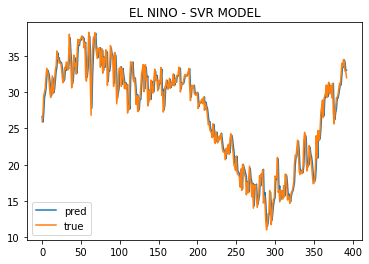

In [52]:
fig, ax = plt.subplots()
ax.plot(regr.predict(X_test), label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')
plt.title('EL NINO - SVR MODEL')
plt.legend()

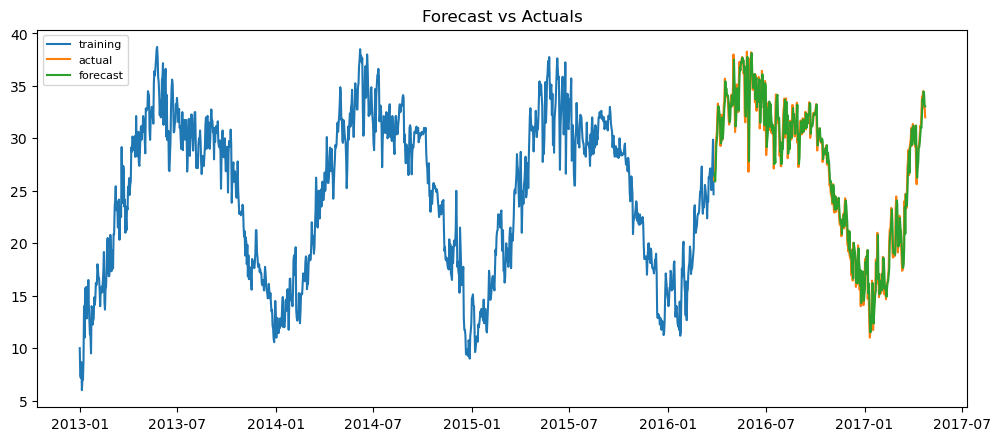

In [59]:
# Forecast
fc = forecast#fitted.forecast(394, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=df_test.index[1:])

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label='training')
plt.plot(df_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Grid Search (TODO: testar outros parametros) 

In [60]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [65]:
#parameters = {'kernel':['linear','rbf'], 'C':[0.1,1,10]}
parameters = {'kernel':['linear','rbf', 'sigmoid', 'polynomial'], 
              #'C':range(0.05, 50, 20),
              'C':np.linspace(0.05, 10, 30),
              #'gamma':np.linspace(.1, 10, 3),
              #'coef0':np.linspace(.01, 10, 3),
              #'degree':np.arange(2, 3)
              }

for p in parameters.items():
  print(p)

('kernel', ['linear', 'rbf', 'sigmoid', 'polynomial'])
('C', array([ 0.05      ,  0.39310345,  0.7362069 ,  1.07931034,  1.42241379,
        1.76551724,  2.10862069,  2.45172414,  2.79482759,  3.13793103,
        3.48103448,  3.82413793,  4.16724138,  4.51034483,  4.85344828,
        5.19655172,  5.53965517,  5.88275862,  6.22586207,  6.56896552,
        6.91206897,  7.25517241,  7.59827586,  7.94137931,  8.28448276,
        8.62758621,  8.97068966,  9.3137931 ,  9.65689655, 10.        ]))


In [66]:
regr2 = SVR()
regrGS = GridSearchCV(regr2, parameters, cv=TimeSeriesSplit())

In [67]:
#%%time
res = regrGS.fit(X_train, y_train)

C:\Users\lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

In [68]:
print(res.best_score_)
print(res.best_params_)
#'C': 0.1, 'coef0': 0.01, 'degree': 2, 'gamma': 0.1, 'kernel': 'linear'
#12 minutos


#'C': 7.788888888888888, 'coef0': 0.01, 'degree': 2, 'gamma': 0.1, 'kernel': 'linear'}
#5 minutos

0.922472901330679
{'C': 10.0, 'kernel': 'rbf'}


In [72]:
forecast = regr.predict(X_test)
show_metrics(y_test, forecast, results, 'SVR GS')

SVR GS - model Results
r2 0.9408686653844883
mse 2.687918103370144
mae 1.2422099872240857
mape 0.049587777671510944


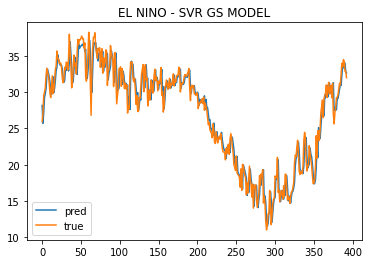

In [70]:
fig, ax = plt.subplots()
ax.plot(res.predict(X_test), label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')
plt.title('EL NINO - SVR GS MODEL')
plt.legend()

In [73]:
pd.DataFrame(results)

,"ARIMA(5,1,3)","ARIMA(2,0,1)",SVR,SVRGS,SVR GS
r2,-14593.473369,-95.858965,0.940869,0.942565,0.940869
mse,48.137529,49.689131,2.687918,2.576197,2.687918
mae,6.243535,6.356183,1.242210,1.226656,1.242210
mape,0.241422,0.262334,0.049588,NaN,0.049588


Usando get_lags

In [74]:
X = get_lags(df, 5)
y = df.reindex(X.index)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.2)

In [79]:
regr_GL = SVR(kernel='linear')
regr_GL.fit(X_train, y_train)

C:\Users\lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVR(kernel='linear')

In [80]:
forecast = regr_GL.predict(X_test)
show_metrics(y_test, forecast, results, 'SVR GL')

SVR GL - model Results
r2 0.9403183104730123
mse 2.5129607027733925
mae 1.2070850477651554
mape 0.05155140833455998


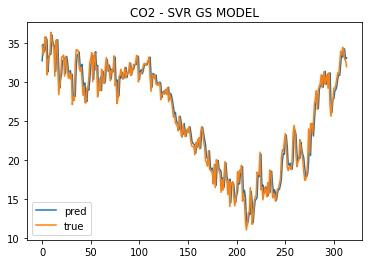

In [81]:
fig, ax = plt.subplots()
ax.plot(regr_GL.predict(X_test), label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')
plt.title('CO2 - SVR GS MODEL')
plt.legend()

In [82]:
pd.DataFrame(results)

,"ARIMA(5,1,3)","ARIMA(2,0,1)",SVR,SVRGS,SVR GS,SVRGL,SVR GL
r2,-14593.473369,-95.858965,0.940869,0.942565,0.940869,0.940318,0.940318
mse,48.137529,49.689131,2.687918,2.576197,2.687918,2.512961,2.512961
mae,6.243535,6.356183,1.242210,1.226656,1.242210,1.207085,1.207085
mape,0.241422,0.262334,0.049588,NaN,0.049588,NaN,0.051551


Verificando Overfitting

In [84]:
train_sizes, train_scores, valid_scores = learning_curve(
    SVR(kernel='linear'), X, y, train_sizes=[50,100,150,200,250], cv=TimeSeriesSplit())
    #SVR(kernel='linear'), X, y, train_sizes=[np.round(np.array(list(range(0.1,1,0.1))) * len(y))], cv=TimeSeriesSplit())

C:\Users\lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

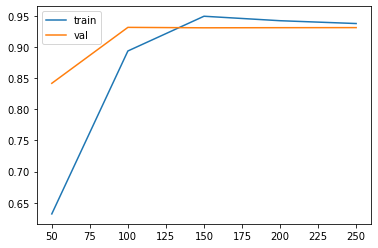

In [85]:
pd.Series(train_scores.mean(axis=1), index=train_sizes).plot(label='train')
pd.Series(valid_scores.mean(axis=1), index=train_sizes).plot(label='val')
plt.legend()

### MLP (TODO: testar arquiteturas e tuning)

In [ ]:
import tensorflow as tf
import os

#### Divisão de Dados MLP 

In [ ]:
#Separando os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.25)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=False, test_size=.25)

#### Diferenciação

In [ ]:
#Diferenciando
X_train_d1 = X_train.diff().dropna()
X_valid_d1 = X_valid.diff().dropna()
X_test_d1 = X_test.diff().dropna()
y_train_d1 = y_train.diff().dropna()
y_valid_d1 = y_valid.diff().dropna()
y_test_d1 = y_test.diff().dropna()

#### Normalização

In [ ]:
X_train_d1_norm = X_train_d1.sub(X_train_d1.mean()).div(X_train_d1.std())
X_valid_d1_norm = X_valid_d1.sub(X_valid_d1.mean()).div(X_valid_d1.std())
X_test_d1_norm = X_test_d1.sub(X_train_d1.mean()).div(X_train_d1.std())

In [ ]:
X_train_d1_norm['meantemp-1'].plot()

In [ ]:
X_train_d1_norm['meantemp-1'].plot.hist(title='train')

In [ ]:
X_valid_d1_norm['meantemp-1'].plot.hist(title='validation')

In [ ]:
X_test_d1_norm['meantemp-1'].plot.hist(title='test')


#### Batches

In [ ]:
training_data = torch.tensor(pd.concat([X_train_d1_norm, y_train_d1], axis=1).values)
validating_data = torch.tensor(pd.concat([X_valid_d1_norm, y_valid_d1], axis=1).values)
testing_data = torch.tensor(pd.concat([X_test_d1_norm, y_test_d1], axis=1).values)


In [ ]:
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=False)
valid_dataloader = DataLoader(validating_data, batch_size=16, shuffle=False)
test_dataloader = DataLoader(testing_data, batch_size=16, shuffle=False)

#### Modelo MLP

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(5,100)
    self.fc3 = nn.Linear(100,1)
    #self.drop1 = nn.Dropout(p=0.5)
    #self.fc2 = nn.Linear(64,32)
    #self.drop2 = nn.Dropout(p=0.5)
  
  def forward(self, X):
    out = torch.tanh(self.fc1(X))
    #out = self.drop1(out)
    #out = torch.relu(self.fc2(out))
    #out = self.drop2(out)
    out = self.fc3(out)
    return out

In [ ]:
multi_neuron = MLP()
print(multi_neuron(torch.tensor(X_train_d1.iloc[0]).float()))
print(y_train_d1.iloc[0])

In [ ]:
multi_neuron = MLP()
epochs = 300
loss_fn = nn.MSELoss()
#optimizer = optim.RMSprop(multi_neuron.parameters(), lr=0.001)
optimizer = optim.SGD(multi_neuron.parameters(), lr=0.01, weight_decay= 0.005)

In [ ]:
history = {}
for epoch in range(1, epochs+1):
  loss_train = 0.0
  for train_data in train_dataloader:
    x = train_data[:,:5].float()
    y = train_data[:,5].float()
  
    #forward pass
    outputs = multi_neuron(x)

    #loss measure
    loss = loss_fn(outputs,y)

    #backward pass
    optimizer.zero_grad() # pára o autograd
    loss.backward() # executa o backpropagation
    optimizer.step() # atualiza os pesos

    loss_train += loss.item() # soma os erros para obter o erro total

  if (epoch % 10 == 0):
    print('Epoch{}, loss {}'.format(epoch, loss_train / len(train_dataloader))) # apresenta o erro médio da época
  history[epoch] = loss_train / len(train_dataloader)

pd.Series(history).plot()

In [ ]:
multi_neuron.eval()
results_MLP = []
for test_data in test_dataloader:
    x = test_data[:,:5].float()
    y = test_data[:,5].float()
    
    y_pred = multi_neuron(x)
    results.extend(y_pred.flatten().detach().numpy())
#pd.DataFrame(results).plot()
results_MLP[:10]

In [ ]:
pd.concat([pd.Series(results_MLP, name='pred'), y_test_d1.reset_index(drop=True)],axis=1).plot()

In [ ]:
print('Prices - MLP Results')
print('r2' ,r2_score(results_MLP, y_test_d1))
print('mse' ,mean_squared_error(results_MLP, y_test_d1))
print('mae', mean_absolute_error(results_MLP, y_test_d1))
results['MLP'] = {'r2':r2_score(results_MLP, y_test_d1), \
                 'mse': mean_squared_error(results_MLP, y_test_d1), 
                 'mae': mean_absolute_error(results_MLP, y_test_d1)}

In [ ]:
pd.DataFrame(results)